Consider the following KdV equation:
$$\frac{\partial u}{∂t} + \frac{∂^3u}{∂x^3} + 6u\frac{∂u}{∂x} = 0, (x,t)∈[-5,5] × [-1,1]$$


<!-- $$u(0, x) = u_0(x) = -\frac{c}{2}{\rm sech}^2(\frac{\sqrt c}{2}(x-a)), x∈[0,1]$$
$$u(t,x) = g(t,x) = -\frac{c}{2}{\rm sech}^2(\frac{\sqrt c}{2}(x-ct-a)), x ∈ \{0, 1\}$$ -->

## 1.Setup

In [65]:
# %%
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time
import copy
import pickle
import os


# %%
torch.set_default_tensor_type('torch.DoubleTensor')
plt.style.use('seaborn-white')
# device = "cuda" if torch.cuda.is_available() else "cpu"

## 2.Hyperparameter

In [66]:
dimension = 2
input_width,layer_width = dimension, 13
# 13, 31, 44, 70

repeat = 3  # Editable
epoch1, epoch2, epoch3 = 30000, 30000, 30000  # Editable
lr = 1e-4  # Editable
data_size = 2000  # Editable
# c = 1
# a = 0

# create directory to save results
if not os.path.exists('data/KdV2_transformation'):
    os.makedirs('data/KdV2_transformation')

# create directory to save temporary results
if not os.path.exists('temp/KdV2_transformation'):
    os.makedirs('temp/KdV2_transformation')

# create directory to save images
if not os.path.exists('images/KdV2_transformation'):
    os.makedirs('images/KdV2_transformation')

## 3.Neural Architecture

In [42]:
# %%
# activation function
def activation(x):
    return x * torch.sigmoid(x)
#     return x * torch.sigmoid(x)


# %%
# build ResNet with one blocks
class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width):
        super(Net,self).__init__()
        self.layer1 = torch.nn.Linear(input_width, layer_width)
        self.layer2 = torch.nn.Linear(layer_width, layer_width)
        self.layer3 = torch.nn.Linear(layer_width, layer_width)
        self.layer4 = torch.nn.Linear(layer_width, 1)
        self.initialize_weights()
    def forward(self,x):
        y = activation(self.layer1(x))
        y = activation(self.layer3(activation(self.layer2(y)))) # residual block 1
        output = self.layer4(y)
        return output
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        # print(self)
        print('Total number of parameters: %d' % num_params)


${\rm N}(\vec{x}) := {\rm A}_{\rm 4}(σ{\rm A}_3({σ}{\rm A}_2({σ}{\rm A}_{\rm 1}(\vec{x}))))$, where

${\rm A}_1: \mathbb{R^2}{→}\mathbb{R}^{\rm width}$, ${\rm A}_2: \mathbb{R}^{\rm width}{→}\mathbb{R}^{\rm width}$, ${\rm A}_3: \mathbb{R}^{\rm width}{→}\mathbb{R}^{\rm width}$, ${\rm A}_4: \mathbb{R}^{\rm width}{→}\mathbb{R}$, 

note: there are `n` parameters need to be trained in total in ${\rm N}(x)$, where

$ {\rm n} = (2 ⋅ {\rm width} + {\rm width}) + 2({\rm width} ⋅ {\rm width} + {\rm width}) + ({\rm width} ⋅ 1 + 1) = 2 ⋅ {\rm width} ^2 + 6 ⋅ {\rm width} + 1$

(5301 for width equal to 50)

## 4.Training setup

### 4.2 Define the exact solution

$$[-5,5]{×}[-1,1]{\ni}(x, t) {↦} u(x, t) = 2({\rm log}f)_{xx} {∈} {\mathbb R}$$

where 

$f = 1 + e^{η_1} + e^{η_2} + e^{η_1+η_2+Α_{12}}$, 

$η_i = k_ix -k_i^3t + η_i^{(0)}$, and 

$e^{Α_{ij}} = (\frac{k_i - k_j}{k_i+k_j})^2$

For initial conditions, the solution is used at $t=0$ and two different sets of values of the parameters are studied, namely:
$k_1 = -2, k_2=4, η_1^{(0)}=\log \frac{1}{3}, η_2^{(0)}=\log \frac{1}{3}$

/* Here we use the second group of the parameters */

In [43]:
def u_ex(X):
    x = X[:,0]
    t = X[:,1]
    # four values shown in the paper
    k1 = -2
    k2 = 4
    eta1 = log(1/3)
    eta2 = log(1/3)

    etaMat1 = (k1*x - k1**3*t + eta1).reshape([x.size()[0], 1])
    etaMat2 = (k2*x - k2**3*t + eta2).reshape([x.size()[0], 1])
    c = ((k1 - k2)/(k1 + k2))**2

    f = 1.0 + torch.exp(etaMat1) + torch.exp(etaMat2) + torch.exp(etaMat1) * torch.exp(etaMat2) * c
    df = k1*torch.exp(etaMat1) + k2*torch.exp(etaMat2) + (k1 + k2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c)
    ddf = (k1**2)*torch.exp(etaMat1) + (k2**2)*torch.exp(etaMat2) + ((k1 + k2)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c)

    y = 2 * (f * ddf - df**2) / (f**2)  # Use chains rule to get the second derivative of lnf in terms of x
    return y.reshape([X.size()[0], 1])

### 4.3 Define $u_0(x)$

<!-- $$ [0,1] {\ni} x {↦} u_0(x) = -\frac{c}{2}sech^2[\frac{\sqrt c}{2}(x-a)]∈ {\mathbb R} $$ -->

$$[-5,5]{\ni}x {↦} u_0(x) = 2({\rm log}f )_{xx}\mid_{t=0} {∈} {\mathbb R}$$

where 

$f = 1 + e^{η_1} + e^{η_2} + e^{η_1+η_2+Α_{12}}$, 

$η_i = k_ix + η_i^{(0)}$, and 

$e^{Α_{ij}} = (\frac{k_i - k_j}{k_i+k_j})^2$

For initial conditions, the solution is used at $t=0$ and two different sets of values of the parameters are studied, namely:
$k_1 = -2, k_2=4, η_1^{(0)}=\log \frac{1}{3}, η_2^{(0)}=\log \frac{1}{3}$

In [44]:
# Define u_0
def u_0x(X):

    x = X[:,0]
    t = X[:,1]
    # four values shown in the paper
    k1 = -2
    k2 = 4
    eta1 = log(1/3)
    eta2 = log(1/3)

    etaMat1 = (k1*x + eta1).reshape([x.size()[0], 1])
    etaMat2 = (k2*x + eta2).reshape([x.size()[0], 1])
    c = ((k1 - k2)/(k1 + k2))**2

    f = 1.0 + torch.exp(etaMat1) + torch.exp(etaMat2) + torch.exp(etaMat1) * torch.exp(etaMat2) * c
    df = k1*torch.exp(etaMat1) + k2*torch.exp(etaMat2) + (k1 + k2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c)
    ddf = (k1**2)*torch.exp(etaMat1) + (k2**2)*torch.exp(etaMat2) + ((k1 + k2)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c)

    y = 2 * (f * ddf - df**2) / (f**2)  # Use chains rule to get the second derivative of lnf in terms of x
    return y.reshape([X.size()[0], 1])

### 4.4 Define g(x,t)

#### 4.4.1 Define g_0(x, t)

<!-- $$ \{0,1\}×[0,1] \ni (x,t) ↦ g(x,t) = -{\frac{1}{2}}{\rm c}sech^2[{\frac{\sqrt {\rm c}}{2}}(x-{\rm c}t-{\rm a})] ∈ {\mathbb R}$$ -->

$$[-1,1]{\ni}t {↦}g_0(t) := u(-5,t) = 2({\rm log}f)_{xx} \mid_{x=-5} {∈} {\mathbb R}$$

where 

$f = 1 + e^{η_1} + e^{η_2} + e^{η_1+η_2+Α_{12}}$, 

$η_i = -5k_i -k_i^3t + η_i^{(0)}$, and 

$e^{Α_{ij}} = (\frac{k_i - k_j}{k_i+k_j})^2$

For initial conditions, the solution is used at $t=0$ and two different sets of values of the parameters are studied, namely:
$k_1 = -2, k_2=4, η_1^{(0)}=\log \frac{1}{3}, η_2^{(0)}=\log \frac{1}{3}$

In [45]:
def g_0x(X):
    x = torch.zeros([X.shape[0],1])[:,0]-5.0
    x.requires_grad = True
    t = X[:,1]
    # four values shown in the paper
    k1 = -2
    k2 = 4
    eta1 = log(1/3)
    eta2 = log(1/3)

    etaMat1 = (k1*x - k1**3*t + eta1).reshape([x.size()[0], 1])
    etaMat2 = (k2*x - k2**3*t + eta2).reshape([x.size()[0], 1])
    c = ((k1 - k2)/(k1 + k2))**2

    f = 1.0 + torch.exp(etaMat1) + torch.exp(etaMat2) + torch.exp(etaMat1) * torch.exp(etaMat2) * c
    df = k1*torch.exp(etaMat1) + k2*torch.exp(etaMat2) + (k1 + k2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c)
    ddf = (k1**2)*torch.exp(etaMat1) + (k2**2)*torch.exp(etaMat2) + ((k1 + k2)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c)

    y = 2 * (f * ddf - df**2) / (f**2)  # Use chains rule to get the second derivative of lnf in terms of x
    return y.reshape([x.size()[0], 1])

#### 4.4.2 Define g_1(t)

$$[-1,1]{\ni}t {↦}g_1(t) := u(5,t) = 2({\rm log}f)_{xx} \mid_{x=5} {∈} {\mathbb R}$$

where 

$f = 1 + e^{η_1} + e^{η_2} + e^{η_1+η_2+Α_{12}}$, 

$η_i = 5k_i -k_i^3t + η_i^{(0)}$, and 

$e^{Α_{ij}} = (\frac{k_i - k_j}{k_i+k_j})^2$

For initial conditions, the solution is used at $t=0$ and two different sets of values of the parameters are studied, namely:
$k_1 = -2, k_2=4, η_1^{(0)}=\log \frac{1}{3}, η_2^{(0)}=\log \frac{1}{3}$

In [46]:
def g_1x(X):
    x = torch.zeros([X.shape[0],1])[:,0]+5.0
    x.requires_grad = True
    t = X[:,1]
    # four values shown in the paper
    k1 = -2
    k2 = 4
    eta1 = log(1/3)
    eta2 = log(1/3)

    etaMat1 = (k1*x - k1**3*t + eta1).reshape([x.size()[0], 1])
    etaMat2 = (k2*x - k2**3*t + eta2).reshape([x.size()[0], 1])
    c = ((k1 - k2)/(k1 + k2))**2

    f = 1.0 + torch.exp(etaMat1) + torch.exp(etaMat2) + torch.exp(etaMat1) * torch.exp(etaMat2) * c
    df = k1*torch.exp(etaMat1) + k2*torch.exp(etaMat2) + (k1 + k2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c)
    ddf = (k1**2)*torch.exp(etaMat1) + (k2**2)*torch.exp(etaMat2) + ((k1 + k2)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c)

    y = 2 * (f * ddf - df**2) / (f**2)  # Use chains rule to get the second derivative of lnf in terms of x
    return y.reshape([x.size()[0], 1])



### 4.5 Build the model

$[-5, 5] \ni x = {\vec X}[:,0]$

$[-1, 1) \ni t = {\vec X}[:,1]$

<!-- $${\rm model}({\vec x}) := {\rm N}({\vec x}) × x × (1-x) × t + x \times t × g(1, t) + (1-x) × t × g(0, t) + (1-t) × x × (1-x) × u_0(x, 0)$$ -->

$${\rm model_{vanilla}}({x, t}) := {\rm N}(x, t)$$

$${\rm model_{boundary-included}}({x,t}) := {\rm N}(x, t) ⋅ \frac{(5+x)}{10} ⋅ \frac{(5-x)}{10} + \frac{(5-x)}{10} ⋅ g_0(t)  + \frac{(5+x)}{10} ⋅ g_1(t)$$

$$f_{\rm {initial-included}}({x,t}) := {\mathcal{N}}(x, t) ⋅ \frac{t^2}{t^2 + q} + \frac{q}{t^2 + q} ⋅ u_0(x)$$



In [47]:
def model1(X):
    term1 = net1(X)
    model_u_temp =  term1
    return model_u_temp.reshape([X.size()[0], 1])

def model2(X):
    x = X[:,0]
    t = X[:,1]
    x_temp = (5.0 + x).reshape([x.size()[0], 1]) / 10
    x_minus = (5.0 - x).reshape([x.size()[0], 1]) / 10

    term1 = net2(X) * x_temp * x_minus
#     term1 = net(X) * x_temp * x_minus * t_temp
    term2 = x_minus * g_0x(X)
    term3 = x_temp * g_1x(X)
    
    model_u_temp =  term1 + term2 + term3
                   
    return model_u_temp.reshape([x.size()[0], 1])

def model3(X):
    q = 1e-8
    x = X[:,0]
    t = torch.square(X[:,1].reshape([x.size()[0], 1]))
    factor1 = t / (t + q)
    factor2 = q / (t + q)

    term1 = net3(X) * factor1
    term2 = factor2 * u_0x(X)
    
    model_u_temp =  term1 + term2
                   
    return model_u_temp.reshape([x.size()[0], 1])

### 4.6 Generate sample

#### 4.6.1 $ν_1$ generator

Generate random points $(x_n, t_n)$ from $[-5,5] × [-1,1]$

In [48]:
# generate points by random
def generate_sample_one(data_size):
    sample_temp = torch.rand(data_size, dimension)
    sample_temp[:,0] = sample_temp[:,0] * 10 - 5
    sample_temp[:,1] = sample_temp[:,1] * 2 - 1
    sample_temp.requires_grad = True
    return sample_temp

#### 4.6.2 $ν_2$ generator

Generate random points $(x_n, t_n)$ from $\{-5,5\} × [-1,1]$

In [49]:
def generate_sample_two(data_size):
    sample_temp = torch.rand(data_size, dimension)
    middle = int(data_size/2)
    sample_temp[:middle, 0] = -5.0
    sample_temp[middle:, 0] = 5.0
    sample_temp[:,1] = sample_temp[:,1] * 2 - 1
    sample_temp.requires_grad = True
    return sample_temp

#### 4.6.3 $ν_3$ generator

Generate random points $x_n$ from $[-5,5]$

In [50]:
def generate_sample_three(data_size):
    sample_temp = torch.rand(data_size, dimension)
    sample_temp[:,1] = 0.0
    sample_temp[:,0] = sample_temp[:,0] * 10 - 5
    sample_temp.requires_grad = True
    return sample_temp

### 4.7 Define Loss function

**(Penalty term: Residual)**

$${\rm Loss_1}(û) = \lVert{\frac{∂û}{∂t}} + {\frac{∂^3û}{∂x^3}} + 6u{\frac{∂û}{∂x}}\rVert^2_{[-5,5]{×}{[-1, 1]},{ν_1}} + \lVert û-g(x) \rVert^2_{{\{-5, 5\}}\times[-1, 1], ν_2} + \lVert û-u_0(x)\rVert^2_{[-5,5], ν_3}$$

**(Penalty term: Residual + initial condition)**

$${\rm Loss_2}(û) = \lVert{\frac{∂û}{∂t}} + {\frac{∂^3û}{∂x^3}} + 6u{\frac{∂û}{∂x}}\rVert^2_{[-5,5]{×}{[-1, 1]},{ν_1}} + \lVert û-u_0(x)\rVert^2_{[-5,5], ν_3}$$

**(Penalty term: Residual + boundary condition)**

$${\rm Loss_3}(û) = \lVert{\frac{∂û}{∂t}} + {\frac{∂^3û}{∂x^3}} + 6u{\frac{∂û}{∂x}}\rVert^2_{[-5,5]{×}{[-1, 1]},{ν_1}} + \lVert û-g(x) \rVert^2_{{\{-5, 5\}}\times[-1, 1], ν_2} $$


In [51]:
# %%
# loss function to DGM by auto differential
def loss_function1(x1, x2, x3):
    # first term
    u_hat = model1(x1)
    grad_u_hat = torch.autograd.grad(outputs = u_hat, inputs = x1, grad_outputs = torch.ones(u_hat.shape), create_graph = True) # dx and dt
    dx = grad_u_hat[0][:, 0].reshape([len(grad_u_hat[0]), 1])  # dx
    dt = grad_u_hat[0][:, 1].reshape([len(grad_u_hat[0]), 1])  # dt
    dxx = torch.autograd.grad(outputs = dx, inputs = x1, grad_outputs = torch.ones(dx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxx
    dxxx = torch.autograd.grad(outputs = dxx, inputs = x1, grad_outputs = torch.ones(dxx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxxx
    loss = torch.sum((dt + dxxx + 6 * u_hat * dx)**2) / len(x1)
    
    # #second term
    u_hat2 = model1(x2)
    middle = int(int(data_size/2)/2)
    gx0 = g_0x(x2)[:middle]
    gx1 = g_1x(x2)[middle:]
    loss2 = torch.sum((u_hat2[:middle] - gx0)**2) / len(x2) + torch.sum((u_hat2[middle:] - gx1)**2) / len(x2)

    # third term
    u_hat3 = model1(x3)
    u0 = u_0x(x3)
    loss3 = torch.sum((u_hat3 - u0) **2) / len(x3)

    return loss + loss2 + loss3


def loss_function2(x1, x2, x3):
    # first term
    u_hat = model2(x1)
    grad_u_hat = torch.autograd.grad(outputs = u_hat, inputs = x1, grad_outputs = torch.ones(u_hat.shape), create_graph = True) # dx and dt
    dx = grad_u_hat[0][:, 0].reshape([len(grad_u_hat[0]), 1])  # dx
    dt = grad_u_hat[0][:, 1].reshape([len(grad_u_hat[0]), 1])  # dt
    dxx = torch.autograd.grad(outputs = dx, inputs = x1, grad_outputs = torch.ones(dx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxx
    dxxx = torch.autograd.grad(outputs = dxx, inputs = x1, grad_outputs = torch.ones(dxx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxxx
    loss = torch.sum((dt + dxxx + 6 * u_hat * dx)**2) / len(x1)
    
    # #second term
    # u_hat2 = model(x2)
    # gx = g_x(x2)
    # loss2 = torch.sum((u_hat2 - gx)**2) / len(x2)

    # third term
    u_hat3 = model2(x3)
    u0 = u_0x(x3)
    loss3 = torch.sum((u_hat3 - u0) **2) / len(x3)

    return loss + loss3


def loss_function3(x1, x2, x3):
    # first term
    u_hat = model3(x1)
    grad_u_hat = torch.autograd.grad(outputs = u_hat, inputs = x1, grad_outputs = torch.ones(u_hat.shape), create_graph = True) # dx and dt
    dx = grad_u_hat[0][:, 0].reshape([len(grad_u_hat[0]), 1])  # dx
    dt = grad_u_hat[0][:, 1].reshape([len(grad_u_hat[0]), 1])  # dt
    dxx = torch.autograd.grad(outputs = dx, inputs = x1, grad_outputs = torch.ones(dx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxx
    dxxx = torch.autograd.grad(outputs = dxx, inputs = x1, grad_outputs = torch.ones(dxx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxxx
    loss = torch.sum((dt + dxxx + 6 * u_hat * dx)**2) / len(x1)
    
    # #second term
    u_hat2 = model3(x2)
    middle = int(int(data_size/2)/2)
    gx0 = g_0x(x2)[:middle]
    gx1 = g_1x(x2)[middle:]
    loss2 = torch.sum((u_hat2[:middle] - gx0)**2) / len(x2) + torch.sum((u_hat2[middle:] - gx1)**2) / len(x2)

    # third term
    # u_hat3 = model(x3)
    # u0 = u_0x(x3)
    # loss3 = torch.sum((u_hat3 - u0) **2) / len(x3)

    return loss + loss2

### 4.7 Define Fractional Error

$${\rm error} = \frac{\lVert \hat u - u \lVert _2^2}{\lVert u \lVert_2^2}$$

In [52]:
def cal_error1(x):
    u_hat = model1(x)
    u = u_ex(x)
    upper = torch.square((u_hat - u).norm(2))
    lower = torch.square(u.norm(2))
    return torch.divide(upper, lower)

def cal_error2(x):
    u_hat = model2(x)
    u = u_ex(x)
    upper = torch.square((u_hat - u).norm(2))
    lower = torch.square(u.norm(2))
    return torch.divide(upper, lower)

def cal_error3(x):
    u_hat = model3(x)
    u = u_ex(x)
    upper = torch.square((u_hat - u).norm(2))
    lower = torch.square(u.norm(2))
    return torch.divide(upper, lower)

## 5.Doing the training

### Generating training data and test data

In [53]:
# Setting training data: 2*|datasize| in total (|datasize| from the space-time domain, |datasize/2| from the t=0 spatial slice, |datasize/2| from the x=0 and x=1 spatial slices)
x = generate_sample_one(data_size)
x2 = generate_sample_two(int(data_size/2)) 
x3 = generate_sample_three(int(data_size/2))

# Testing data
test_data = torch.zeros((301, 201, 2))
for i in range(0, 301):
  x_test = i / 30 - 5
  for j in range(201):
    t_test = j / 100 - 1
    test_data[i][j][0] = x_test
    test_data[i][j][1] = t_test
test_data = torch.reshape(test_data, (301*201, 2))

In [54]:
# %%
loss1_all = []
error1_all = []
u_hat_1_all = []
for t in range(repeat):
  print("Time: ", t+1, "/{}".format(repeat))

  net1 = Net(input_width,layer_width)
  optimizer1 = optim.Adam(net1.parameters(), lr=lr)

  loss_record1 = np.zeros(epoch1)
  error_record1 = np.zeros(epoch1)

  time_start = time.time()
  for i in range(1, epoch1+1):
      optimizer1.zero_grad()
      loss1 = loss_function1(x, x2, x3)
      error1 = cal_error1(test_data)
      loss_record1[i-1] = float(loss1)
      error_record1[i-1] = float(error1)
      loss1.backward()
      optimizer1.step() 
      torch.cuda.empty_cache() # clear memory
      if i % 2000 == 0 or i == 1:
        print("current epoch: ", i)
        print("current loss: ", loss1.detach())
        print("current error: ", error1.detach())
      
  time_end = time.time()
  u_hat_1_all.append(model1(test_data).detach().numpy())
  loss1_all.append(loss_record1)
  error1_all.append(error_record1)
  print('total time is: ', time_end-time_start, 'seconds')

# save loss1_all, error1_all, u_hat_1_all using pickle
with open('data/KdV2_transformation/KdV2_loss1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(loss1_all, f)

with open('data/KdV2_transformation/KdV2_error1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(error1_all, f)

with open('data/KdV2_transformation/KdV2_u_hat_1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(u_hat_1_all, f)

Time:  1 /3
current epoch:  1
current loss:  tensor(5.9388)
current error:  tensor(0.9954)
total time is:  0.06311392784118652 seconds
Time:  2 /3
current epoch:  1
current loss:  tensor(6.4753)
current error:  tensor(1.1308)
total time is:  0.05675005912780762 seconds
Time:  3 /3
current epoch:  1
current loss:  tensor(6.0919)
current error:  tensor(1.0487)
total time is:  0.05584406852722168 seconds


In [55]:
loss2_all = []
error2_all = []
u_hat_2_all = []
for t in range(repeat):
  print("Time: ", t+1, "/{}".format(repeat))

  net2 = Net(input_width,layer_width)
  optimizer2 = optim.Adam(net2.parameters(), lr=lr)

  loss_record2 = np.zeros(epoch2)
  error_record2 = np.zeros(epoch2)

  time_start = time.time()
  for i in range(1, epoch2+1):
      optimizer2.zero_grad()
      loss2 = loss_function2(x, x2, x3)
      error2 = cal_error2(test_data)
      loss_record2[i-1] = float(loss2)
      error_record2[i-1] = float(error2)
      loss2.backward()
      optimizer2.step() 
      torch.cuda.empty_cache() # clear memory
      if i % 2000 == 0 or i == 1:
        print("current epoch: ", i)
        print("current loss: ", loss2.detach())
        print("current error: ", error2.detach())
      
  time_end = time.time()
  u_hat_2_all.append(model2(test_data).detach().numpy())
  loss2_all.append(loss_record2)
  error2_all.append(error_record2)
  print('total time is: ', time_end-time_start, 'seconds')

# save loss2_all, error2_all, u_hat_2_all using pickle
with open('data/KdV2_transformation/KdV2_loss2_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch2, lr, layer_width), 'wb') as f:
  pickle.dump(loss2_all, f)

with open('data/KdV2_transformation/KdV2_error2_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch2, lr, layer_width), 'wb') as f:
  pickle.dump(error2_all, f)

with open('data/KdV2_transformation/KdV2_u_hat_2_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch2, lr, layer_width), 'wb') as f:
  pickle.dump(u_hat_2_all, f)

Time:  1 /3
current epoch:  1
current loss:  tensor(731.5958)
current error:  tensor(1.1416)
total time is:  0.1285860538482666 seconds
Time:  2 /3
current epoch:  1
current loss:  tensor(731.2833)
current error:  tensor(1.1513)
total time is:  0.11683297157287598 seconds
Time:  3 /3
current epoch:  1
current loss:  tensor(731.7135)
current error:  tensor(1.1429)
total time is:  0.11552786827087402 seconds


In [56]:
loss3_all = []
error3_all = []
u_hat_3_all = []
for t in range(repeat):
  print("Time: ", t+1, "/{}".format(repeat))

  net3 = Net(input_width,layer_width)
  optimizer3 = optim.Adam(net3.parameters(), lr=lr)

  loss_record3 = np.zeros(epoch3)
  error_record3 = np.zeros(epoch3)

  time_start = time.time()
  for i in range(1, epoch3+1):
      optimizer3.zero_grad()
      loss3 = loss_function3(x, x2, x3)
      error3 = cal_error3(test_data)
      loss_record3[i-1] = float(loss3)
      error_record3[i-1] = float(error3)
      loss3.backward()
      optimizer3.step() 
      torch.cuda.empty_cache() # clear memory
      if i % 2000 == 0 or i == 1:
        print("current epoch: ", i)
        print("current loss: ", loss3.detach())
        print("current error: ", error3.detach())
      
  time_end = time.time()
  u_hat_3_all.append(model3(test_data).detach().numpy())
  loss3_all.append(loss_record3)
  error3_all.append(error_record3)
  print('total time is: ', time_end-time_start, 'seconds')

# save loss3_all, error3_all, u_hat_3_all using pickle
with open('data/KdV2_transformation/KdV2_loss3_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch3, lr, layer_width), 'wb') as f:
  pickle.dump(loss3_all, f)

with open('data/KdV2_transformation/KdV2_error3_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch3, lr, layer_width), 'wb') as f:
  pickle.dump(error3_all, f)

with open('data/KdV2_transformation/KdV2_u_hat_3_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch3, lr, layer_width), 'wb') as f:
  pickle.dump(u_hat_3_all, f)

Time:  1 /3
current epoch:  1
current loss:  tensor(4.4613)
current error:  tensor(0.9437)
total time is:  0.09166407585144043 seconds
Time:  2 /3
current epoch:  1
current loss:  tensor(13.8423)
current error:  tensor(1.0762)
total time is:  0.09065079689025879 seconds
Time:  3 /3
current epoch:  1
current loss:  tensor(12.1568)
current error:  tensor(1.0101)
total time is:  0.08184599876403809 seconds


In [104]:
# load loss1_all, error1_all, u_hat_1_all using pickle
data_size = 2000
epoch1, epoch2, epoch3 = 30000, 30000, 30000
lr = 0.0001
repeat = 3
layer_width = 13

with open('src/data/KdV2_transformation_v2/KdV2_loss1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, layer_width), 'rb') as f:
    loss1_all = pickle.load(f)

with open('src/data/KdV2_transformation_v2/KdV2_error1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, layer_width), 'rb') as f:
    error1_all = pickle.load(f)

with open('src/data/KdV2_transformation_v2/KdV2_u_hat_1_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch1, lr, layer_width), 'rb') as f:
    u_hat_1_all = pickle.load(f)

# load loss2_all, error2_all, u_hat_2_all using pickle
with open('src/data/KdV2_transformation_v2/KdV2_loss2_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch2, lr, layer_width), 'rb') as f:
    loss2_all = pickle.load(f)

with open('src/data/KdV2_transformation_v2/KdV2_error2_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch2, lr, layer_width), 'rb') as f:
    error2_all = pickle.load(f)

with open('src/data/KdV2_transformation_v2/KdV2_u_hat_2_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch2, lr, layer_width), 'rb') as f:
    u_hat_2_all = pickle.load(f)

# load loss3_all, error3_all, u_hat_3_all using pickle
with open('src/data/KdV2_transformation_v2/KdV2_loss3_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch3, lr, layer_width), 'rb') as f:
    loss3_all = pickle.load(f)

with open('src/data/KdV2_transformation_v2/KdV2_error3_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch3, lr, layer_width), 'rb') as f:
    error3_all = pickle.load(f)

with open('src/data/KdV2_transformation_v2/KdV2_u_hat_3_all_{}_{}_{}_{}.pkl'.format(data_size*2, epoch3, lr, layer_width), 'rb') as f:
    u_hat_3_all = pickle.load(f)

## 6.Plotting the output

### Plot the Exmperical Loss & Fractional Error

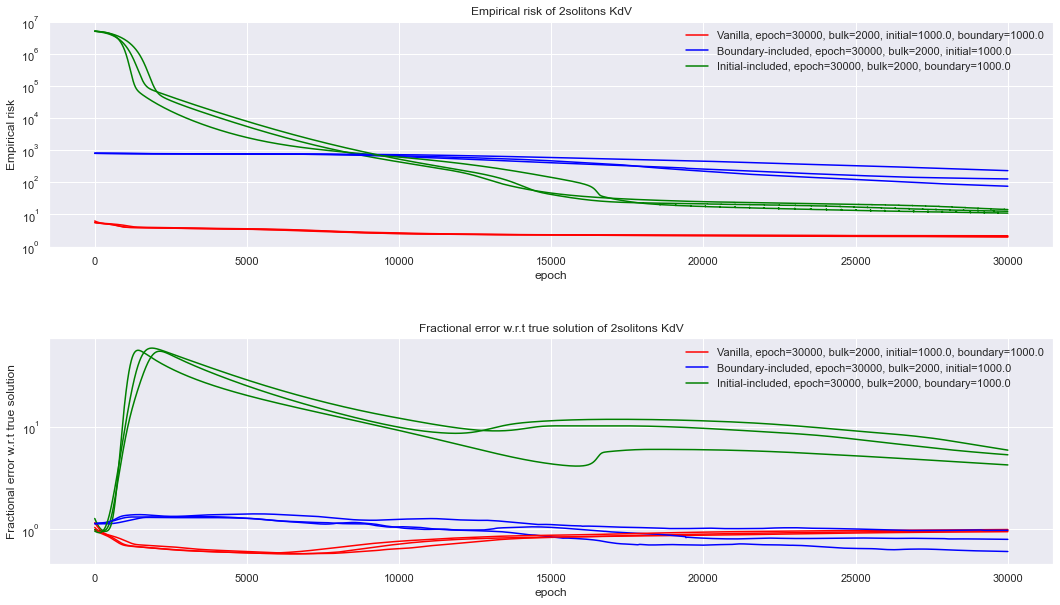

In [105]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(10)
fig.set_figwidth(18)

ax = fig.add_subplot(2, 1, 1)
for i in range(repeat):
    ax.plot(loss1_all[i], label = 'Vanilla, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2) if i==0 else None, color = 'red')
    ax.plot(loss2_all[i], label = 'Boundary-included, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2) if i==0 else None, color = 'blue')
    ax.plot(loss3_all[i], label = 'Initial-included, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2) if i==0 else None, color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Empirical risk')
ax.set_title("Empirical risk of 2solitons KdV")
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot(2, 1, 2)
for i in range(repeat):
    ax.plot(error1_all[i], label = 'Vanilla, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2) if i==0 else None, color = 'red')
    ax.plot(error2_all[i], label = 'Boundary-included, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2) if i==0 else None, color = 'blue')
    ax.plot(error3_all[i], label = 'Initial-included, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2) if i==0 else None, color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Fractional error w.r.t true solution')
ax.set_title("Fractional error w.r.t true solution of 2solitons KdV")
ax.set_yscale("log")
ax.legend()

# save the figure
fig.savefig('images/KdV2_transformation/KdV2_loss_error_{}_{}_{}_{}.png'.format(data_size*2, epoch3, lr, layer_width))

### Plot the variance of the loss and error

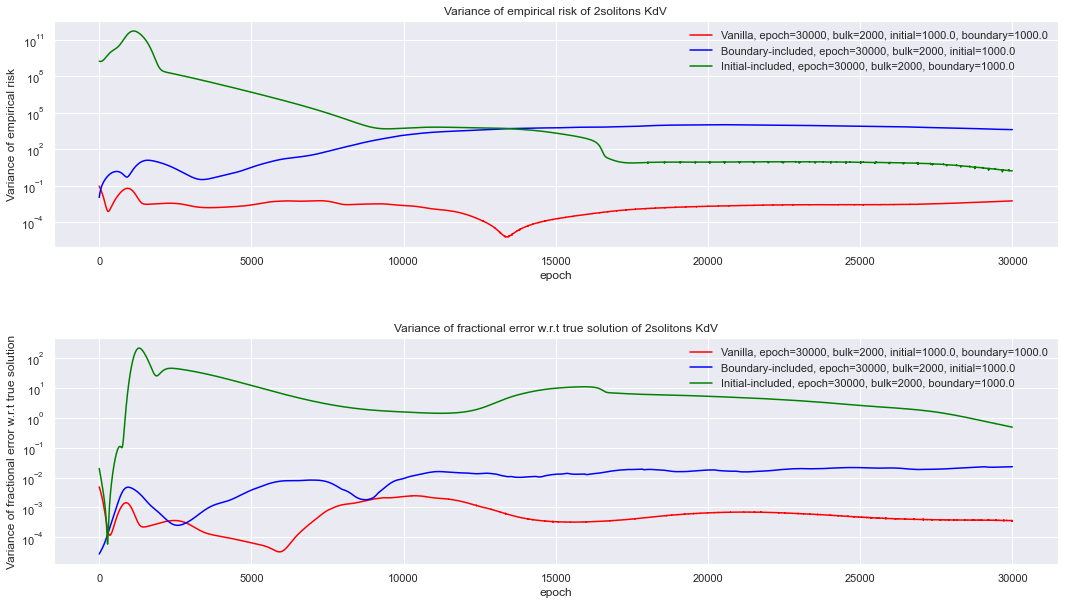

In [106]:
# calculate the variance of loss1_all and error1_all in column direction
var_loss1_all = np.array(loss1_all).var(axis=0)
var_error1_all = np.array(error1_all).var(axis=0)

# calculate the variance of loss2_all and error2_all in column direction
var_loss2_all = np.array(loss2_all).var(axis=0)
var_error2_all = np.array(error2_all).var(axis=0)

# calculate the variance of loss3_all and error3_all in column direction
var_loss3_all = np.array(loss3_all).var(axis=0)
var_error3_all = np.array(error3_all).var(axis=0)

# Plot all the variance of loss and error
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(10)
fig.set_figwidth(18)

ax = fig.add_subplot(2, 1, 1)
ax.plot(var_loss1_all, label = 'Vanilla, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
ax.plot(var_loss2_all, label = 'Boundary-included, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2), color = 'blue')
ax.plot(var_loss3_all, label = 'Initial-included, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2), color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Variance of empirical risk')
ax.set_title("Variance of empirical risk of 2solitons KdV")
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot(2, 1, 2)
ax.plot(var_error1_all, label = 'Vanilla, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
ax.plot(var_error2_all, label = 'Boundary-included, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2), color = 'blue')
ax.plot(var_error3_all, label = 'Initial-included, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2), color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Variance of fractional error w.r.t true solution')
ax.set_title("Variance of fractional error w.r.t true solution of 2solitons KdV")
ax.set_yscale("log")
ax.legend()

# save the figure
fig.savefig('images/KdV2_transformation/KdV2_loss_error_var_{}_{}_{}_{}.png'.format(data_size*2, epoch3, lr, layer_width))

### Plot the average of the loss and error

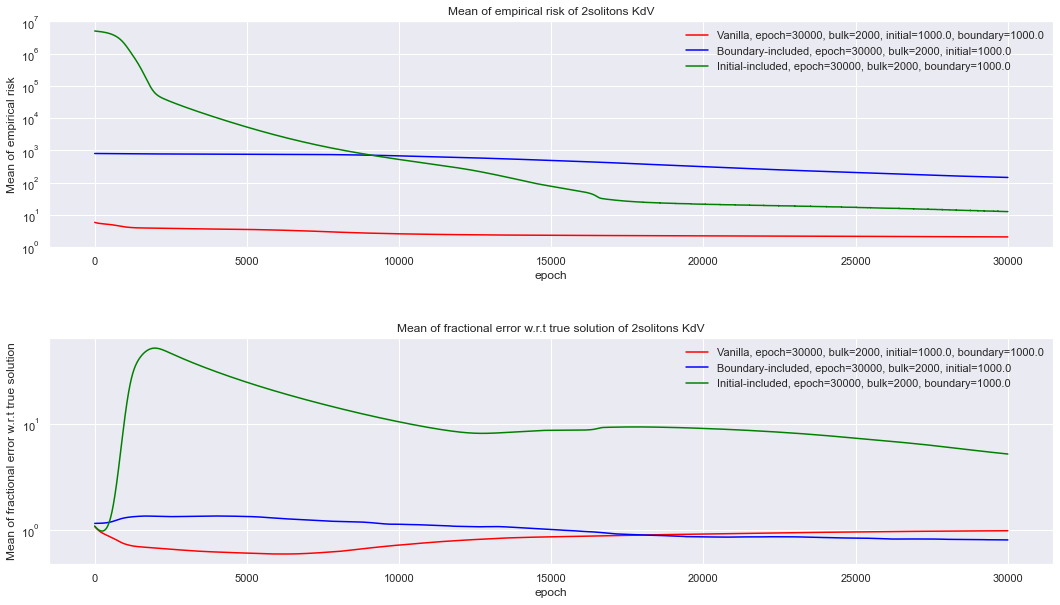

In [107]:
# calculate the mean of loss1_all and error1_all in column direction
mean_loss1_all = np.array(loss1_all).mean(axis=0)
mean_error1_all = np.array(error1_all).mean(axis=0)

# calculate the mean of loss2_all and error2_all in column direction
mean_loss2_all = np.array(loss2_all).mean(axis=0)
mean_error2_all = np.array(error2_all).mean(axis=0)

# calculate the mean of loss3_all and error3_all in column direction
mean_loss3_all = np.array(loss3_all).mean(axis=0)
mean_error3_all = np.array(error3_all).mean(axis=0)

# Plot all the mean of loss and error
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(10)
fig.set_figwidth(18)

ax = fig.add_subplot(2, 1, 1)
ax.plot(mean_loss1_all, label = 'Vanilla, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
ax.plot(mean_loss2_all, label = 'Boundary-included, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2), color = 'blue')
ax.plot(mean_loss3_all, label = 'Initial-included, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2), color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Mean of empirical risk')
ax.set_title("Mean of empirical risk of 2solitons KdV")
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot(2, 1, 2)
ax.plot(mean_error1_all, label = 'Vanilla, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
ax.plot(mean_error2_all, label = 'Boundary-included, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2), color = 'blue')
ax.plot(mean_error3_all, label = 'Initial-included, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2), color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Mean of fractional error w.r.t true solution')
ax.set_title("Mean of fractional error w.r.t true solution of 2solitons KdV")
ax.set_yscale("log")
ax.legend()

# save the figure
fig.savefig('images/KdV2_transformation/KdV2_loss_error_mean_{}_{}_{}_{}.png'.format(data_size*2, epoch3, lr, layer_width))

### Plot the error bar

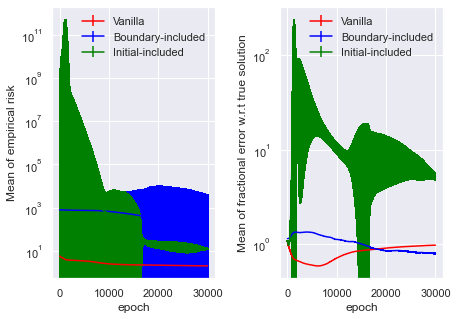

In [108]:
# Plot the error bar of loss and error
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(5)
fig.set_figwidth(7)

ax = fig.add_subplot(1, 2, 1)
ax.errorbar(range(epoch1), mean_loss1_all, yerr=var_loss1_all, label = 'Vanilla', color = 'red')
ax.errorbar(range(epoch2), mean_loss2_all, yerr=var_loss2_all, label = 'Boundary-included', color = 'blue')
ax.errorbar(range(epoch3), mean_loss3_all, yerr=var_loss3_all, label = 'Initial-included', color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Mean of empirical risk')
# ax.set_title("Mean of empirical loss")
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.errorbar(range(epoch1), mean_error1_all, yerr=var_error1_all, label = 'Vanilla', color = 'red')
ax.errorbar(range(epoch2), mean_error2_all, yerr=var_error2_all, label = 'Boundary-included', color = 'blue')
ax.errorbar(range(epoch3), mean_error3_all, yerr=var_error3_all, label = 'Initial-included', color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Mean of fractional error w.r.t true solution')
# ax.set_title("Mean of fractional error w.r.t true solution")
ax.set_yscale("log")
ax.legend()

# save the figure
fig.savefig('images/KdV2_transformation/KdV2_loss_error_errorbar_{}_{}_{}_{}.png'.format(data_size*2, epoch3, lr, layer_width))


### Plot the heat map Using 100 $\times$ 100 test data

In [101]:
data_u_hat_1 = np.reshape(np.array(u_hat_1_all).mean(axis=0), (301,201))
data_u_hat_2 = np.reshape(np.array(u_hat_2_all).mean(axis=0), (301,201))
data_u_hat_3 = np.reshape(np.array(u_hat_3_all).mean(axis=0), (301,201))
data_u = torch.reshape(u_ex(test_data), (301, 201)).detach().numpy()

# Generate x and y labels
x_axis_labels = []
y_axis_labels = []
for i in range(301):
  if i%30 == 0:
    y_axis_labels.append(i/30-5)
  else:
    y_axis_labels.append("")

for i in range(201):
  if i%20 == 0:
    x_axis_labels.append(np.round(i/100 - 1, 2).item())
  else:
    x_axis_labels.append("")

/var/folders/yl/m5cgc23j1gbfcvxxglrgsk0w0000gn/T/ipykernel_2022/2497353140.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


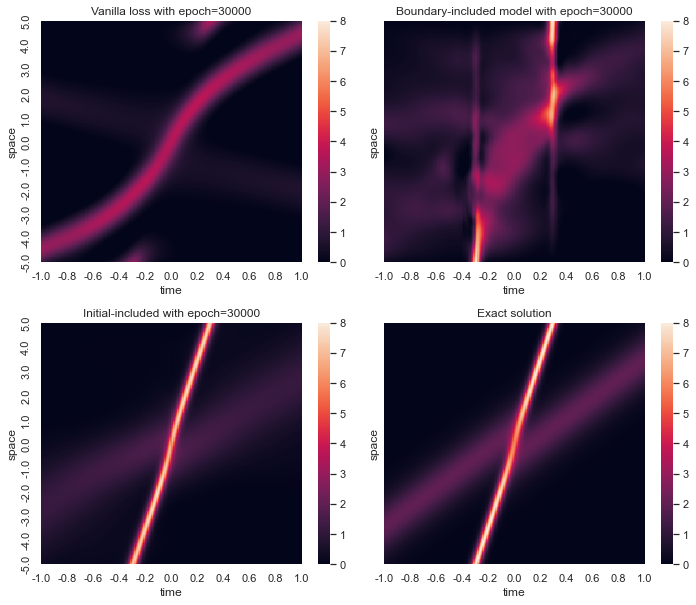

In [103]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,10)})



f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharey=True)
# set the subplot gap of the figure
fig.tight_layout()
plt.subplots_adjust(hspace=0.25, wspace=0.05)
# set font size
sns.set(font_scale=1)

g1 = sns.heatmap(data_u_hat_1, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=8, ax=ax1)
# reverse the y axis
ax1.set_xlabel('time')
ax1.set_ylabel('space')
ax1.invert_yaxis()
g1.set_title('Vanilla loss with epoch=30000')
g2 = sns.heatmap(data_u_hat_2, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=8, ax=ax2)
ax2.set_xlabel('time')
ax2.set_ylabel('space')
ax2.invert_yaxis()
g2.set_title("Boundary-included model with epoch=30000")
g1 = sns.heatmap(data_u_hat_3, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=8, ax=ax3)
ax3.set_xlabel('time')
ax3.set_ylabel('space')
ax3.invert_yaxis()
g1.set_title('Initial-included with epoch=30000')
g2 = sns.heatmap(data_u, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=8, ax=ax4)
ax4.set_xlabel('time')
ax4.set_ylabel('space')
ax4.invert_yaxis()
g2.set_title("Exact solution")

# save the figure   
f.savefig("images/KdV2_transformation/model_transformation_2sol_{}_{}_{}_{}.png".format(epoch1, epoch2, epoch3, layer_width))

In [98]:
# print the mean of loss and error for each model
print("The final average loss1 is {}".format(mean_loss1_all[-1]))
print("The final average error1 is {}".format(mean_error1_all[-1]))

print("The final average loss2 is {}".format(mean_loss2_all[-1]))
print("The final average error2 is {}".format(mean_error2_all[-1]))

print("The final average loss3 is {}".format(mean_loss3_all[-1]))
print("The final average error3 is {}".format(mean_error3_all[-1]))

The final average loss1 is 1.6535948144871642
The final average error1 is 1.119738715054252
The final average loss2 is 27.598234408159176
The final average error2 is 1.5027786161150292
The final average loss3 is 1.2089254162387497
The final average error3 is 0.8842365432743536
